In [18]:
import pandas as pd
import os

# Get the current working directory and establish the data path
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'db')

# Read the CSV files with proper path joining
core_trial_info = pd.read_csv(os.path.join(data_dir, 'core_trial_info.csv'))
endpoints = pd.read_csv(os.path.join(data_dir, 'endpoints_processed.csv'))
biomarkers = pd.read_csv(os.path.join(data_dir, 'biomarkers_processed.csv'))

# Select the columns we want to merge from biomarkers
biomarker_cols = biomarkers.columns[biomarkers.columns.get_loc('biomarker_diagnostic'):biomarkers.columns.get_loc('has_inflammatory')+1]

# Select the columns we want to merge from endpoints
endpoint_cols = endpoints.columns[endpoints.columns.get_loc('Trial Outcomes'):endpoints.columns.get_loc('outcome_completed')+1]

# Merge the data
# First merge with biomarkers
merged_data = pd.merge(
    core_trial_info,
    biomarkers[['Trial.ID'] + list(biomarker_cols)],
    on='Trial.ID',
    how='left'
)

# Then merge with endpoints
merged_data = pd.merge(
    merged_data,
    endpoints[['Trial.ID'] + list(endpoint_cols)],
    on='Trial.ID',
    how='left'
)

# Save the merged dataset with proper path joining
output_path = os.path.join(data_dir, 'merged_trial_data.csv')
merged_data.to_csv(output_path, index=False)

# Print some basic information about the merged dataset
print(f"Current working directory: {current_dir}")
print(f"Data directory: {data_dir}")
print(f"Shape of merged dataset: {merged_data.shape}")
print("\nColumns in merged dataset:")
print(merged_data.columns.tolist())

FileNotFoundError: [Errno 2] No such file or directory: '/users/PAS2598/duarte63/GitHub/clinical-trial-als-deepl/notebooks/db/core_trial_info.csv'

In [21]:
# Cell 1: Imports and Configuration (Updated for Comprehensive Dataset)
import torch as tc
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score, 
                           precision_score, recall_score, f1_score, balanced_accuracy_score,
                           classification_report)
import copy
import warnings
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

class ModelConfig:
    """Configuration class for comprehensive dataset model parameters"""
    
    def __init__(self, data_path='/users/PAS2598/duarte63/GitHub/clinical-trial-als-deepl/db/comprehensive_merged_trial_data.csv'):
        # Data params - updated for comprehensive dataset
        self.data_file = data_path
        self.target_column = 'reached_phase_3_plus'
        self.id_column = 'Trial.ID'
        
        # Model params - optimized for larger feature set
        self.hidden_depth_simple = 3          # Increased depth for more features
        self.factor_hidden_nodes = 2          
        self.device = 'cuda' if tc.cuda.is_available() else 'cpu'
        self.batch_size = 64
        self.lr = 3e-4                        # Slightly lower for stability
        self.dropout = 0.3                    # Reduced dropout
        self.input_dropout = 0.15             # Reduced input dropout
        self.weight_decay = 1e-4
        self.splits = 5
        self.lrp_gamma = 0.01
        self.l1_lambda = 1e-5
        self.early_stopping_patience = 15     # More patience for complex model
        
        # Class balancing
        self.use_class_weights = True
        self.pos_weight_factor = 2.5
        
        # Feature exclusion
        self.exclude_phase_features = True

# Initialize configuration
config = ModelConfig()
print(f"Using device: {config.device}")
if tc.cuda.is_available():
    print(f"GPU: {tc.cuda.get_device_name()}")

# Set random seeds for reproducibility
tc.manual_seed(42)
np.random.seed(42)

print("Configuration updated for comprehensive dataset with 120 columns")

Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Configuration updated for comprehensive dataset with 120 columns


In [22]:
# Cell 2: Data Loading and Analysis (Updated for Comprehensive Dataset)
def load_and_analyze_comprehensive_data(filepath):
    """Load and analyze the comprehensive 120-column dataset"""
    
    df = pd.read_csv(filepath)
    
    print(f"Comprehensive Dataset loaded: {df.shape[0]} trials, {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Check target variable
    target_col = 'reached_phase_3_plus'
    target_dist = df[target_col].value_counts()
    success_rate = target_dist.get(1, 0) / len(df) * 100
    print(f"\nTarget distribution: {target_dist.get(1, 0)}/{len(df)} Phase 3+ trials ({success_rate:.1f}% success rate)")
    
    # Analyze comprehensive feature categories
    print(f"\n=== COMPREHENSIVE FEATURES ANALYSIS ===")
    
    # Sponsor features analysis
    sponsor_features = [col for col in df.columns if col.startswith('sponsor_')]
    print(f"\nSponsor Features ({len(sponsor_features)} columns):")
    if 'sponsor_is_industry' in df.columns:
        industry_pct = df['sponsor_is_industry'].sum() / len(df) * 100
        print(f"  Industry sponsors: {df['sponsor_is_industry'].sum():3d} trials ({industry_pct:4.1f}%)")
    if 'sponsor_is_academic' in df.columns:
        academic_pct = df['sponsor_is_academic'].sum() / len(df) * 100
        print(f"  Academic sponsors: {df['sponsor_is_academic'].sum():3d} trials ({academic_pct:4.1f}%)")
    if 'sponsor_country_usa' in df.columns:
        usa_pct = df['sponsor_country_usa'].sum() / len(df) * 100
        print(f"  US-based sponsors: {df['sponsor_country_usa'].sum():3d} trials ({usa_pct:4.1f}%)")
    if 'sponsor_is_major_pharma' in df.columns:
        major_pharma_pct = df['sponsor_is_major_pharma'].sum() / len(df) * 100
        print(f"  Major pharma: {df['sponsor_is_major_pharma'].sum():3d} trials ({major_pharma_pct:4.1f}%)")
    
    # Patient characteristics analysis
    patient_features = [col for col in df.columns if col.startswith(('patient_', 'includes_', 'gender_', 'age_group_'))]
    print(f"\nPatient Characteristics ({len(patient_features)} columns):")
    if 'gender_both' in df.columns:
        both_gender_pct = df['gender_both'].sum() / len(df) * 100
        print(f"  Both genders: {df['gender_both'].sum():3d} trials ({both_gender_pct:4.1f}%)")
    if 'includes_elderly' in df.columns:
        elderly_pct = df['includes_elderly'].sum() / len(df) * 100
        print(f"  Include elderly: {df['includes_elderly'].sum():3d} trials ({elderly_pct:4.1f}%)")
    if 'patient_age_range' in df.columns:
        avg_age_range = df['patient_age_range'].mean()
        print(f"  Average age range: {avg_age_range:.1f} years")
    
    # Enrollment & timeline analysis
    enrollment_features = [col for col in df.columns if 'enrollment' in col.lower() or 'accrual' in col.lower() or 'duration' in col.lower()]
    print(f"\nEnrollment & Timeline ({len(enrollment_features)} columns):")
    if 'Actual Accrual (% of Target)' in df.columns:
        avg_accrual = df['Actual Accrual (% of Target)'].mean()
        print(f"  Average enrollment achievement: {avg_accrual:.1f}% of target")
    if 'study_duration_days' in df.columns:
        avg_duration = df['study_duration_days'].mean()
        print(f"  Average study duration: {avg_duration:.0f} days")
    if 'Treatment Duration (Mos.)' in df.columns:
        avg_treatment = df['Treatment Duration (Mos.)'].mean()
        print(f"  Average treatment duration: {avg_treatment:.1f} months")
    
    # Original enhanced features
    endpoint_cols = ['endpoint_efficacy', 'endpoint_safety', 'endpoint_functional', 
                    'endpoint_biomarker', 'endpoint_survival', 'endpoint_pharmacokinetic']
    
    print(f"\nOriginal Enhanced Endpoint Categories:")
    for col in endpoint_cols:
        if col in df.columns:
            coverage = (df[col] > 0).sum()
            avg_mentions = df[col].mean()
            print(f"  {col.replace('endpoint_', '').title():<15}: {coverage:3d} trials ({coverage/len(df)*100:4.1f}%) - Avg: {avg_mentions:.2f}")
    
    # Biomarker analysis
    biomarker_use_cols = ['biomarker_diagnostic', 'biomarker_predictive', 
                         'biomarker_prognostic', 'biomarker_predisposing']
    
    print(f"\nBiomarker Use Categories:")
    for col in biomarker_use_cols:
        if col in df.columns:
            coverage = df[col].sum()
            print(f"  {col.replace('biomarker_', '').title():<15}: {coverage:3d} trials ({coverage/len(df)*100:4.1f}%)")
    
    # Data completeness by feature category
    print(f"\n=== DATA COMPLETENESS BY CATEGORY ===")
    feature_categories = {
        'Sponsor': [col for col in df.columns if col.startswith('sponsor_')],
        'Patient': [col for col in df.columns if col.startswith(('patient_', 'includes_', 'gender_', 'age_group_'))],
        'Enrollment': [col for col in df.columns if any(keyword in col.lower() for keyword in ['enrollment', 'accrual', 'duration', 'study_'])],
        'Endpoint': [col for col in df.columns if col.startswith('endpoint_')],
        'Biomarker': [col for col in df.columns if col.startswith(('biomarker_', 'has_'))],
        'Outcome': [col for col in df.columns if col.startswith('outcome_')],
    }
    
    for category, cols in feature_categories.items():
        if cols:
            category_df = df[cols]
            completeness = (1 - category_df.isnull().sum().sum() / (len(category_df) * len(cols))) * 100
            print(f"  {category:<12}: {len(cols):2d} columns, {completeness:5.1f}% complete")
    
    return df

# Load the comprehensive dataset
df = load_and_analyze_comprehensive_data(config.data_file)

Comprehensive Dataset loaded: 962 trials, 120 columns
Memory usage: 10.68 MB

Target distribution: 219/962 Phase 3+ trials (22.8% success rate)

=== COMPREHENSIVE FEATURES ANALYSIS ===

Sponsor Features (15 columns):
  Industry sponsors: 547 trials (56.9%)
  Academic sponsors: 439 trials (45.6%)
  US-based sponsors: 245 trials (25.5%)
  Major pharma: 362 trials (37.6%)

Patient Characteristics (15 columns):
  Both genders: 712 trials (74.0%)
  Include elderly: 384 trials (39.9%)
  Average age range: 26.4 years

Enrollment & Timeline (12 columns):
  Average enrollment achievement: 31.4% of target
  Average study duration: 0 days
  Average treatment duration: 4.5 months

Original Enhanced Endpoint Categories:
  Efficacy       : 609 trials (63.3%) - Avg: 2.98
  Safety         : 583 trials (60.6%) - Avg: 6.09
  Functional     : 397 trials (41.3%) - Avg: 1.26
  Biomarker      : 402 trials (41.8%) - Avg: 1.21
  Survival       : 347 trials (36.1%) - Avg: 1.12
  Pharmacokinetic: 295 trials (30

In [26]:
# Cell 3: Comprehensive Feature Extraction Functions

def extract_keywords_features(df):
    """Extract individual keywords from Study Keywords column"""
    
    if 'Study Keywords' not in df.columns:
        return pd.DataFrame()
    
    # Extract all individual keywords
    all_keywords = []
    for keywords_str in df['Study Keywords'].dropna():
        keywords = [kw.strip().lower() for kw in str(keywords_str).split(';')]
        all_keywords.extend(keywords)
    
    # Count keyword frequency and create features for common keywords
    keyword_counts = Counter(all_keywords)
    common_keywords = [kw for kw, count in keyword_counts.items() if count >= 5]
    
    # Create keyword features
    keyword_features = pd.DataFrame(index=df.index)
    for keyword in common_keywords:
        feature_name = f"keyword_{keyword.replace(' ', '_').replace('/', '_')}"
        keyword_features[feature_name] = df['Study Keywords'].apply(
            lambda x: 1 if pd.notna(x) and keyword in str(x).lower() else 0
        )
    
    print(f"Extracted {len(keyword_features.columns)} keyword features from {len(common_keywords)} common keywords")
    return keyword_features


def extract_mesh_features(df):
    """Extract individual MeSH terms"""
    
    if 'MeSH Term' not in df.columns:
        return pd.DataFrame()
    
    # Extract all individual MeSH terms
    all_mesh = []
    for mesh_str in df['MeSH Term'].dropna():
        terms = [term.strip() for term in str(mesh_str).split(';')]
        all_mesh.extend(terms)
    
    # Count term frequency and create features for common terms
    mesh_counts = Counter(all_mesh)
    common_mesh = [term for term, count in mesh_counts.items() if count >= 5]
    
    # Create MeSH features
    mesh_features = pd.DataFrame(index=df.index)
    for term in common_mesh:
        feature_name = f"mesh_{term.replace(' ', '_').replace(',', '').replace('(', '').replace(')', '').lower()}"
        mesh_features[feature_name] = df['MeSH Term'].apply(
            lambda x: 1 if pd.notna(x) and term in str(x) else 0
        )
    
    print(f"Extracted {len(mesh_features.columns)} MeSH features from {len(common_mesh)} common terms")
    return mesh_features


def get_comprehensive_features(df):
    """Extract all features from the comprehensive 120-column dataset"""
    
    feature_sets = []
    feature_names = []
    
    # 1. SPONSOR FEATURES (22 new columns) - HIGH IMPACT EXPECTED
    sponsor_features = [
        'sponsor_is_industry', 'sponsor_is_academic', 'sponsor_is_government', 'sponsor_is_nonprofit',
        'sponsor_type_complexity', 'sponsor_country_usa', 'sponsor_country_europe', 'sponsor_country_asia',
        'sponsor_country_diversity', 'sponsor_state_california', 'sponsor_state_massachusetts', 
        'sponsor_state_major_biotech', 'sponsor_trial_count', 'sponsor_is_major_pharma',
        'has_multiple_sponsors', 'has_supporting_urls', 'supporting_url_count'
    ]
    
    # 2. PATIENT CHARACTERISTICS (35 new columns) - VERY HIGH IMPACT EXPECTED
    patient_features = [
        'patient_min_age', 'patient_max_age', 'patient_age_range', 'includes_children',
        'includes_adults', 'includes_elderly', 'age_group_breadth', 'age_group_children',
        'age_group_adults', 'age_group_older_adults', 'gender_both',
        'gender_male_only', 'gender_female_only', 'gender_restricted',
        'inclusion_has_diagnosis', 'inclusion_has_age_requirement', 'inclusion_has_consent',
        'inclusion_has_functional_requirement', 'inclusion_criteria_length',
        'exclusion_has_comorbidity', 'exclusion_has_medication', 'exclusion_has_pregnancy',
        'exclusion_has_cognitive', 'exclusion_criteria_length', 'population_has_specific_type',
        'population_has_severity', 'population_has_duration', 'population_description_length',
        'total_criteria_length', 'demographic_restrictions'
    ]
    
    # 3. ENROLLMENT & TIMELINE (21 new columns) - HIGH IMPACT EXPECTED
    enrollment_features = [
        'Actual Accrual (% of Target)', 'Actual Accrual (No. of patients)', 'Target Accrual',
        'Treatment Duration (Mos.)', 'Enrollment Duration (Mos.)', 'Pts/Site/Mo',
        'study_start_date', 'study_duration_days'
    ]
    
    # 4. ORIGINAL ENHANCED FEATURES (keep existing)
    existing_enhanced_features = [
        'endpoint_efficacy', 'endpoint_safety', 'endpoint_functional', 'endpoint_biomarker',
        'endpoint_survival', 'endpoint_pharmacokinetic', 'endpoint_total_categories',
        'biomarker_diagnostic', 'biomarker_predictive', 'biomarker_prognostic', 
        'biomarker_predisposing', 'biomarker_total_uses', 'biomarker_count',
        'has_sod1', 'has_albumin', 'has_neurofilament', 'has_nfl', 'has_tau', 
        'has_tdp-43', 'has_c9orf72', 'has_creatinine', 'has_inflammatory',
        'outcome_positive', 'outcome_negative', 'outcome_terminated', 'outcome_completed'
    ]
    
    # Collect all numeric features
    all_numeric_features = sponsor_features + patient_features + enrollment_features + existing_enhanced_features
    existing_numeric = [col for col in all_numeric_features if col in df.columns]
    
    if existing_numeric:
        numeric_df = df[existing_numeric].fillna(0)
        feature_sets.append(numeric_df)
        feature_names.extend(existing_numeric)
        print(f"Added {len(existing_numeric)} comprehensive numeric features")
    
    # 5. CATEGORICAL FEATURES (encode new categorical columns)
    categorical_features = [
        'sponsor_experience_level', 'inclusion_criteria_complexity', 
        'exclusion_criteria_complexity', 'population_specificity', 
        'patient_selectivity', 'study_duration_category'
    ]
    
    for col in categorical_features:
        if col in df.columns and df[col].notna().sum() > 0:
            encoded = pd.get_dummies(df[col], prefix=col, dummy_na=False)
            feature_sets.append(encoded)
            feature_names.extend(encoded.columns)
            print(f"Added {len(encoded.columns)} features from {col}")
    
    # 6. EXISTING CATEGORICAL FEATURES
    existing_categorical = ['Trial Status', 'Disease', 'endpoint_primary_category']
    for col in existing_categorical:
        if col in df.columns:
            if col == 'Disease':
                value_counts = df[col].value_counts()
                top_categories = value_counts.head(10).index.tolist()
                df_temp = df[col].apply(lambda x: x if x in top_categories else 'Other')
                encoded = pd.get_dummies(df_temp, prefix=col.replace(' ', '_'), dummy_na=True)
            else:
                encoded = pd.get_dummies(df[col], prefix=col.replace(' ', '_'), dummy_na=True)
            
            feature_sets.append(encoded)
            feature_names.extend(encoded.columns)
            print(f"Added {len(encoded.columns)} features from {col}")
    
    # 7. TEXT FEATURES (keep existing keyword/MeSH extraction)
    keyword_features = extract_keywords_features(df)
    if len(keyword_features.columns) > 0:
        feature_sets.append(keyword_features)
        feature_names.extend(keyword_features.columns)
    
    mesh_features = extract_mesh_features(df)
    if len(mesh_features.columns) > 0:
        feature_sets.append(mesh_features)
        feature_names.extend(mesh_features.columns)
    
    if not feature_sets:
        raise ValueError("No features could be extracted from the dataset")
    
    # Combine all features
    X_combined = pd.concat(feature_sets, axis=1)
    
    return X_combined, feature_names

# Test the comprehensive feature extraction
print("Testing comprehensive feature extraction...")
X_test, feature_names_test = get_comprehensive_features(df)
print(f"Total features extracted: {len(feature_names_test)}")
print(f"Feature matrix shape: {X_test.shape}")

Testing comprehensive feature extraction...
Added 81 comprehensive numeric features
Added 4 features from sponsor_experience_level
Added 4 features from inclusion_criteria_complexity
Added 4 features from exclusion_criteria_complexity
Added 4 features from population_specificity
Added 4 features from patient_selectivity
Added 2 features from study_duration_category
Added 7 features from Trial Status
Added 12 features from Disease
Added 8 features from endpoint_primary_category
Extracted 22 keyword features from 22 common keywords
Extracted 33 MeSH features from 33 common terms
Total features extracted: 185
Feature matrix shape: (962, 185)


In [27]:
# Cell 4: Comprehensive Data Preprocessing

def preprocess_comprehensive_data(df, config):
    """Comprehensive preprocessing for the 120-column dataset with all features"""
    
    # Target variable
    y = df[config.target_column]
    
    # Extract all comprehensive features
    X_combined, feature_names = get_comprehensive_features(df)
    
    # Feature selection: remove low-variance features
    print(f"\nApplying variance threshold filtering...")
    variance_selector = VarianceThreshold(threshold=0.005)  # Slightly lower threshold for more features
    X_variance_filtered = variance_selector.fit_transform(X_combined.values)
    selected_features = [feature_names[i] for i in range(len(feature_names)) 
                        if i < len(variance_selector.get_support()) and variance_selector.get_support()[i]]
    
    print(f"Features after variance filtering: {len(selected_features)} (removed {len(feature_names) - len(selected_features)})")
    
    # Convert to numpy and standardize
    X_array = X_variance_filtered.astype(np.float32)
    y_array = y.values.astype(np.float32)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_array)
    
    # Create phase groups for stratification (use Trial Status if available)
    if 'Trial Status' in df.columns:
        phase_groups = df['Trial Status'].values
    else:
        phase_groups = df.get('Trial Phase', pd.Series(['Unknown'] * len(df))).values
    
    print(f"Final preprocessed shape: {X_scaled.shape}")
    
    return X_scaled, y_array, phase_groups, selected_features, scaler


def remove_phase_leakage(X_scaled, feature_names, config):
    """Remove trial phase features that leak target information"""
    
    if not config.exclude_phase_features:
        return X_scaled, feature_names
    
    # Identify phase-related features that might leak information
    phase_features = []
    leakage_patterns = ['trial_phase', 'phase_', '_phase', 'completed', 'terminated']
    
    for i, name in enumerate(feature_names):
        name_lower = name.lower()
        if any(pattern in name_lower for pattern in leakage_patterns):
            # Keep outcome features as they are legitimate predictors, but remove direct phase info
            if not name_lower.startswith('outcome_') and not name_lower.startswith('endpoint_'):
                phase_features.append(i)
    
    if phase_features:
        # Remove phase features
        mask = [i for i in range(len(feature_names)) if i not in phase_features]
        X_filtered = X_scaled[:, mask]
        feature_names_filtered = [feature_names[i] for i in mask]
        
        print(f"Removed {len(phase_features)} potential leakage features")
        removed_features = [feature_names[i] for i in phase_features]
        print(f"Removed features: {removed_features[:5]}{'...' if len(removed_features) > 5 else ''}")
        return X_filtered, feature_names_filtered
    else:
        print("No phase leakage features detected")
        return X_scaled, feature_names


def analyze_comprehensive_feature_categories(feature_names):
    """Analyze the distribution of comprehensive feature categories"""
    
    categories = {
        'Sponsor': [],
        'Patient': [],
        'Enrollment': [],
        'Endpoint': [],
        'Biomarker': [],
        'Outcome': [],
        'Keywords': [],
        'MeSH': [],
        'Primary_Endpoint': [],
        'Categorical': [],
        'Other': []
    }
    
    for feature in feature_names:
        feature_lower = feature.lower()
        if feature_lower.startswith('sponsor_'):
            categories['Sponsor'].append(feature)
        elif any(feature_lower.startswith(prefix) for prefix in ['patient_', 'includes_', 'gender_', 'age_group_', 'inclusion_', 'exclusion_', 'population_', 'demographic_']):
            categories['Patient'].append(feature)
        elif any(keyword in feature_lower for keyword in ['enrollment', 'accrual', 'duration', 'study_', 'pts/site']):
            categories['Enrollment'].append(feature)
        elif feature_lower.startswith('endpoint_'):
            categories['Endpoint'].append(feature)
        elif feature_lower.startswith('biomarker_') or feature_lower.startswith('has_'):
            categories['Biomarker'].append(feature)
        elif feature_lower.startswith('outcome_'):
            categories['Outcome'].append(feature)
        elif feature_lower.startswith('keyword_'):
            categories['Keywords'].append(feature)
        elif feature_lower.startswith('mesh_'):
            categories['MeSH'].append(feature)
        elif feature_lower.startswith('primary_endpoint'):
            categories['Primary_Endpoint'].append(feature)
        elif any(cat in feature_lower for cat in ['trial_status', 'disease', 'therapeutic_area', '_complexity', '_specificity', '_selectivity', '_category']):
            categories['Categorical'].append(feature)
        else:
            categories['Other'].append(feature)
    
    print(f"\n=== COMPREHENSIVE FEATURE CATEGORIES ANALYSIS ===")
    for category, features in categories.items():
        if features:
            print(f"{category:<15}: {len(features):3d} features")
    
    # Detailed breakdown for new feature categories
    print(f"\n=== NEW FEATURE CATEGORIES BREAKDOWN ===")
    sponsor_subcategories = {
        'Type': [f for f in categories['Sponsor'] if any(x in f for x in ['is_industry', 'is_academic', 'is_government', 'is_nonprofit'])],
        'Geography': [f for f in categories['Sponsor'] if any(x in f for x in ['country_', 'state_'])],
        'Experience': [f for f in categories['Sponsor'] if any(x in f for x in ['trial_count', 'experience', 'major_pharma'])],
        'Collaboration': [f for f in categories['Sponsor'] if any(x in f for x in ['multiple', 'supporting', 'url'])]
    }
    
    patient_subcategories = {
        'Demographics': [f for f in categories['Patient'] if any(x in f for x in ['age', 'gender'])],
        'Inclusion': [f for f in categories['Patient'] if 'inclusion_' in f],
        'Exclusion': [f for f in categories['Patient'] if 'exclusion_' in f],
        'Population': [f for f in categories['Patient'] if 'population_' in f]
    }
    
    print(f"\nSponsor subcategories:")
    for subcat, features in sponsor_subcategories.items():
        if features:
            print(f"  {subcat:<12}: {len(features):2d} features")
    
    print(f"\nPatient subcategories:")
    for subcat, features in patient_subcategories.items():
        if features:
            print(f"  {subcat:<12}: {len(features):2d} features")
    
    return categories

# Run the comprehensive preprocessing
print("Running comprehensive preprocessing...")
X, y, phase_groups, feature_names, scaler = preprocess_comprehensive_data(df, config)

# Remove phase leakage features
X, feature_names = remove_phase_leakage(X, feature_names, config)

# Analyze feature categories
feature_categories = analyze_comprehensive_feature_categories(feature_names)

print(f"\nFinal comprehensive dataset shape: {X.shape}")
print(f"Target distribution: {int(y.sum())}/{len(y)} Phase 3+ trials ({y.mean()*100:.1f}% success rate)")
print(f"Expected significant performance improvement with {len(feature_categories['Sponsor']) + len(feature_categories['Patient']) + len(feature_categories['Enrollment'])} new operational features")

Running comprehensive preprocessing...
Added 81 comprehensive numeric features
Added 4 features from sponsor_experience_level
Added 4 features from inclusion_criteria_complexity
Added 4 features from exclusion_criteria_complexity
Added 4 features from population_specificity
Added 4 features from patient_selectivity
Added 2 features from study_duration_category
Added 7 features from Trial Status
Added 12 features from Disease
Added 8 features from endpoint_primary_category
Extracted 22 keyword features from 22 common keywords
Extracted 33 MeSH features from 33 common terms

Applying variance threshold filtering...
Features after variance filtering: 169 (removed 16)
Final preprocessed shape: (962, 169)
Removed 2 potential leakage features
Removed features: ['Trial_Status_Completed', 'Trial_Status_Terminated']

=== COMPREHENSIVE FEATURE CATEGORIES ANALYSIS ===
Sponsor        :  17 features
Patient        :  44 features
Enrollment     :   8 features
Endpoint       :  14 features
Biomarker 

In [34]:
# Cell 5: Enhanced Neural Network Model Classes

class LRP_Linear(nn.Module):
    """Linear layer with Layer-wise Relevance Propagation capability"""
    
    def __init__(self, inp, outp, gamma=0.01, eps=1e-5):
        super(LRP_Linear, self).__init__()
        self.A_dict = {}
        self.linear = nn.Linear(inp, outp)
        nn.init.xavier_uniform_(self.linear.weight, gain=nn.init.calculate_gain('relu'))
        self.gamma = tc.tensor(gamma)
        self.eps = tc.tensor(eps)
        self.iteration = None

    def forward(self, x):
        if not self.training:
            self.A_dict[self.iteration] = x.clone()
        return self.linear(x)

    def relprop(self, R):
        device = next(self.parameters()).device
        A = self.A_dict[self.iteration].clone()
        A, self.eps = A.to(device), self.eps.to(device)

        Ap = A.clamp(min=0).detach().data.requires_grad_(True)
        Am = A.clamp(max=0).detach().data.requires_grad_(True)

        zpp = self.newlayer(1).forward(Ap)  
        zmm = self.newlayer(-1, no_bias=True).forward(Am) 
        zmp = self.newlayer(1, no_bias=True).forward(Am) 
        zpm = self.newlayer(-1).forward(Ap) 

        with tc.no_grad():
            Y = self.forward(A).data

        sp = ((Y > 0).float() * R / (zpp + zmm + self.eps * ((zpp + zmm == 0).float() + tc.sign(zpp + zmm)))).data
        sm = ((Y < 0).float() * R / (zmp + zpm + self.eps * ((zmp + zpm == 0).float() + tc.sign(zmp + zpm)))).data

        (zpp * sp).sum().backward()
        cpp = Ap.grad
        Ap.grad = None
        Ap.requires_grad_(True)

        (zpm * sm).sum().backward()
        cpm = Ap.grad
        Ap.grad = None
        Ap.requires_grad_(True)

        (zmp * sm).sum().backward()
        cmp = Am.grad
        Am.grad = None
        Am.requires_grad_(True)

        (zmm * sp).sum().backward()
        cmm = Am.grad
        Am.grad = None
        Am.requires_grad_(True)

        R_1 = (Ap * cpp).data
        R_2 = (Ap * cpm).data
        R_3 = (Am * cmp).data
        R_4 = (Am * cmm).data

        return R_1 + R_2 + R_3 + R_4

    def newlayer(self, sign, no_bias=False):
        if sign == 1:
            rho = lambda p: p + self.gamma * p.clamp(min=0)
        else:
            rho = lambda p: p + self.gamma * p.clamp(max=0)

        layer_new = copy.deepcopy(self.linear)
        try:
            layer_new.weight = nn.Parameter(rho(self.linear.weight))
        except AttributeError:
            pass

        try:
            layer_new.bias = nn.Parameter(self.linear.bias * 0 if no_bias else rho(self.linear.bias))
        except AttributeError:
            pass

        return layer_new


class LRP_ReLU(nn.Module):
    """ReLU layer with LRP capability"""
    
    def __init__(self):
        super(LRP_ReLU, self).__init__()
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x)

    def relprop(self, R):
        return R


class LRP_DropOut(nn.Module):
    """Dropout layer with LRP capability"""
    
    def __init__(self, p):
        super(LRP_DropOut, self).__init__()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        return self.dropout(x)

    def relprop(self, R):
        return R


class LRP_BatchNorm1d(nn.Module):
    """BatchNorm layer with LRP capability"""
    
    def __init__(self, num_features):
        super(LRP_BatchNorm1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)

    def forward(self, x):
        return self.bn(x)

    def relprop(self, R):
        return R


class ALS_Comprehensive_Model(nn.Module):
    """Enhanced neural network model for comprehensive ALS clinical trials prediction"""
    
    def __init__(self, n_features, config):
        super(ALS_Comprehensive_Model, self).__init__()
        self.classname = 'ALS Comprehensive Clinical Trials Model'
        
        inp = n_features
        # Larger architecture for comprehensive feature set
        hidden_1 = min(512, max(256, n_features * 2))
        hidden_2 = hidden_1 // 2
        hidden_3 = hidden_2 // 2
        outp = 1
        
        # Input processing
        self.input_bn = LRP_BatchNorm1d(inp)
        self.input_dropout = LRP_DropOut(config.input_dropout)
        
        # First hidden layer
        self.fc1 = LRP_Linear(inp, hidden_1, gamma=config.lrp_gamma)
        self.bn1 = LRP_BatchNorm1d(hidden_1)
        self.relu1 = LRP_ReLU()
        self.dropout1 = LRP_DropOut(config.dropout)
        
        # Second hidden layer
        self.fc2 = LRP_Linear(hidden_1, hidden_2, gamma=config.lrp_gamma)
        self.bn2 = LRP_BatchNorm1d(hidden_2)
        self.relu2 = LRP_ReLU()
        self.dropout2 = LRP_DropOut(config.dropout)
        
        # Third hidden layer
        self.fc3 = LRP_Linear(hidden_2, hidden_3, gamma=config.lrp_gamma)
        self.relu3 = LRP_ReLU()
        self.dropout3 = LRP_DropOut(config.dropout)
        
        # Output layer
        self.fc_out = LRP_Linear(hidden_3, outp, gamma=config.lrp_gamma)
        self.sigmoid = nn.Sigmoid()
        
        self.hidden_depth = 3
        
        # Store architecture info
        self.architecture = f"{inp} -> {hidden_1} -> {hidden_2} -> {hidden_3} -> {outp}"
        
        # Count parameters
        self.n_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        print(f"Model architecture: {self.architecture}")
        print(f"Total parameters: {self.n_parameters:,}")

    def forward(self, x):
        x = self.input_bn(x)
        x = self.input_dropout(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        
        x = self.fc_out(x)
        return self.sigmoid(x)

    def relprop(self, R):
        R = self.fc_out.relprop(R)
        R = self.dropout3.relprop(R)
        R = self.relu3.relprop(R)
        R = self.fc3.relprop(R)
        R = self.dropout2.relprop(R)
        R = self.relu2.relprop(R)
        R = self.bn2.relprop(R)
        R = self.fc2.relprop(R)
        R = self.dropout1.relprop(R)
        R = self.relu1.relprop(R)
        R = self.bn1.relprop(R)
        R = self.fc1.relprop(R)
        R = self.input_dropout.relprop(R)
        R = self.input_bn.relprop(R)
        
        return R


print("Enhanced neural network model classes defined successfully")
print(f"Comprehensive model will use {X.shape[1]} input features with 3-layer architecture")

Enhanced neural network model classes defined successfully
Comprehensive model will use 167 input features with 3-layer architecture


In [37]:
# Cell 6: Enhanced Training and Evaluation Functions

def train_comprehensive_model(X_train, y_train, X_val, y_val, config):
    """Train the comprehensive neural network model"""
    
    n_features = X_train.shape[1]
    model = ALS_Comprehensive_Model(n_features, config).to(config.device)
    
    # Calculate class weights
    pos_count = y_train.sum()
    neg_count = len(y_train) - pos_count
    pos_weight = tc.tensor([config.pos_weight_factor], device=config.device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = tc.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)
    
    # Convert to tensors
    X_train_tensor = tc.tensor(X_train, dtype=tc.float32, device=config.device)
    y_train_tensor = tc.tensor(y_train, dtype=tc.float32, device=config.device)
    X_val_tensor = tc.tensor(X_val, dtype=tc.float32, device=config.device)
    y_val_tensor = tc.tensor(y_val, dtype=tc.float32, device=config.device)
    
    best_f1 = 0
    best_model_state = None
    patience_counter = 0
    training_history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_auc': []}
    
    print(f"Training model with {model.n_parameters:,} parameters...")
    
    for epoch in range(150):  # Increased max epochs for complex model
        # Training
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor).squeeze()
        loss = criterion(outputs, y_train_tensor)
        
        # L1 regularization
        l1_loss = sum(p.abs().sum() for p in model.parameters())
        total_loss = loss + config.l1_lambda * l1_loss
        
        total_loss.backward()
        
        # Gradient clipping for stability
        tc.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Validation
        model.eval()
        with tc.no_grad():
            val_outputs = model(X_val_tensor).squeeze()
            val_loss = criterion(val_outputs, y_val_tensor)
            val_probs = tc.sigmoid(val_outputs).cpu().numpy()
        
        # Calculate metrics for early stopping
        thresholds = np.arange(0.2, 0.8, 0.05)
        best_val_f1 = 0
        for thresh in thresholds:
            val_f1 = f1_score(y_val, (val_probs > thresh).astype(int), zero_division=0)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
        
        # Calculate AUC for validation
        try:
            val_auc = roc_auc_score(y_val, val_probs)
        except ValueError:
            val_auc = 0.0
        
        # Store training history
        training_history['train_loss'].append(loss.item())
        training_history['val_loss'].append(val_loss.item())
        training_history['val_f1'].append(best_val_f1)
        training_history['val_auc'].append(val_auc)
        
        scheduler.step(best_val_f1)
        
        # Early stopping based on F1 score
        if best_val_f1 > best_f1:
            best_f1 = best_val_f1
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss: {loss.item():.4f}, Val F1: {best_val_f1:.4f}, Val AUC: {val_auc:.4f}")
        
        if patience_counter >= config.early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, epoch + 1, best_f1, training_history


def evaluate_comprehensive_model(model, X_test, y_test, config):
    """Evaluate comprehensive model and return comprehensive metrics"""
    
    model.eval()
    X_test_tensor = tc.tensor(X_test, dtype=tc.float32, device=config.device)
    
    with tc.no_grad():
        outputs = model(X_test_tensor).squeeze()
        probs = tc.sigmoid(outputs).cpu().numpy()
    
    # Find optimal threshold using multiple metrics
    thresholds = np.arange(0.1, 0.9, 0.02)
    best_f1 = 0
    best_thresh = 0.5
    best_balanced_acc = 0
    
    for thresh in thresholds:
        predictions = (probs > thresh).astype(int)
        f1 = f1_score(y_test, predictions, zero_division=0)
        balanced_acc = balanced_accuracy_score(y_test, predictions)
        
        # Use balanced accuracy as primary metric, F1 as secondary
        if balanced_acc > best_balanced_acc or (balanced_acc == best_balanced_acc and f1 > best_f1):
            best_f1 = f1
            best_thresh = thresh
            best_balanced_acc = balanced_acc
    
    # Calculate comprehensive metrics
    try:
        auc = roc_auc_score(y_test, probs)
        ap = average_precision_score(y_test, probs)
        
        predictions = (probs > best_thresh).astype(int)
        accuracy = accuracy_score(y_test, predictions)
        balanced_acc = balanced_accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, zero_division=0)
        recall = recall_score(y_test, predictions, zero_division=0)
        f1 = f1_score(y_test, predictions, zero_division=0)
        
    except ValueError as e:
        print(f"Warning: Metric calculation issue: {e}")
        auc = ap = accuracy = balanced_acc = precision = recall = f1 = 0.0
        best_thresh = 0.5
    
    return auc, ap, accuracy, balanced_acc, precision, recall, f1, best_thresh, probs


def perform_comprehensive_lrp_analysis(model, X_test, y_test, feature_names, config):
    """Perform Layer-wise Relevance Propagation analysis with comprehensive features"""
    
    model.eval()
    X_test_tensor = tc.tensor(X_test, dtype=tc.float32, device=config.device)
    
    # Set iteration for LRP
    for layer in model.modules():
        if hasattr(layer, 'iteration'):
            layer.iteration = 0
    
    # Forward pass
    with tc.no_grad():
        outputs = model(X_test_tensor).squeeze()
        probs = tc.sigmoid(outputs).cpu().numpy()
    
    # LRP analysis
    R = tc.ones_like(outputs, device=config.device)
    relevance_scores = model.relprop(R).cpu().numpy()
    
    # Calculate feature importance
    feature_importance = np.abs(relevance_scores).mean(axis=0)
    feature_importance_dict = dict(zip(feature_names, feature_importance))
    feature_importance_series = pd.Series(feature_importance_dict).sort_values(ascending=False)
    
    return feature_importance_series, relevance_scores, probs


def create_detailed_classification_report(y_true, y_pred, y_probs, threshold):
    """Create a detailed classification report with additional metrics"""
    
    print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
    print(f"Optimal Threshold: {threshold:.3f}")
    print(f"Test Set Size: {len(y_true)} samples")
    print(f"Positive Class: {int(y_true.sum())} samples ({y_true.mean()*100:.1f}%)")
    print(f"Negative Class: {int((1-y_true).sum())} samples ({(1-y_true.mean())*100:.1f}%)")
    
    # Confusion matrix components
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    tn = ((y_pred == 0) & (y_true == 0)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    
    print(f"\nConfusion Matrix:")
    print(f"  True Positives:  {tp:3d}")
    print(f"  True Negatives:  {tn:3d}")
    print(f"  False Positives: {fp:3d}")
    print(f"  False Negatives: {fn:3d}")
    
    # Calculate metrics manually for verification
    precision_manual = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_manual = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"\nDetailed Metrics:")
    print(f"  Sensitivity (Recall): {recall_manual:.3f}")
    print(f"  Specificity:          {specificity:.3f}")
    print(f"  Precision (PPV):      {precision_manual:.3f}")
    print(f"  NPV:                  {tn/(tn+fn) if (tn+fn) > 0 else 0:.3f}")
    
    # Probability distribution analysis
    pos_probs = y_probs[y_true == 1]
    neg_probs = y_probs[y_true == 0]
    
    print(f"\nProbability Distribution:")
    print(f"  Positive samples - Mean: {pos_probs.mean():.3f}, Std: {pos_probs.std():.3f}")
    print(f"  Negative samples - Mean: {neg_probs.mean():.3f}, Std: {neg_probs.std():.3f}")
    
    return {
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'sensitivity': recall_manual,
        'specificity': specificity,
        'precision': precision_manual,
        'pos_prob_stats': {'mean': pos_probs.mean(), 'std': pos_probs.std()},
        'neg_prob_stats': {'mean': neg_probs.mean(), 'std': neg_probs.std()}
    }

print("Enhanced training and evaluation functions defined successfully")

Enhanced training and evaluation functions defined successfully


In [38]:
# Cell 7: Comprehensive Cross-Validation and Results

def run_comprehensive_cross_validation(X, y, phase_groups, feature_names, config):
    """Run cross-validation with comprehensive evaluation for the enhanced dataset"""
    
    print(f"Starting {config.splits}-fold cross-validation with comprehensive features...")
    print(f"Dataset: {len(y)} trials, {X.shape[1]} features")
    print(f"Target: {int(y.sum())}/{len(y)} Phase 3+ trials ({y.mean()*100:.1f}% success rate)")
    print(f"Expected significant improvement with comprehensive sponsor, patient, and enrollment features")
    
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=config.splits, shuffle=True, random_state=42)
    
    cv_results = []
    best_auc = 0
    best_fold_data = None
    all_training_histories = []
    
    for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\nFold {fold}/{config.splits}: ", end="")
        
        # Split data
        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]
        
        # Further split train_val into train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
        )
        
        # Train comprehensive model
        model, epochs, best_val_f1, training_history = train_comprehensive_model(X_train, y_train, X_val, y_val, config)
        all_training_histories.append(training_history)
        
        # Evaluate model
        auc, ap, accuracy, balanced_acc, precision, recall, f1, best_thresh, probs = evaluate_comprehensive_model(model, X_test, y_test, config)
        
        # Store results
        fold_results = {
            'fold': fold,
            'auc': auc,
            'average_precision': ap,
            'accuracy': accuracy,
            'balanced_accuracy': balanced_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'optimal_threshold': best_thresh,
            'epochs': epochs,
            'validation_f1': best_val_f1,
            'n_test_samples': len(y_test),
            'test_positives': int(y_test.sum()),
            'model_parameters': model.n_parameters
        }
        cv_results.append(fold_results)
        
        print(f"AUC: {auc:.3f}, F1: {f1:.3f}, Bal.Acc: {balanced_acc:.3f}, Epochs: {epochs}")
        
        # Store best fold for detailed analysis
        if auc > best_auc:
            best_auc = auc
            feature_importance, relevance_scores, _ = perform_comprehensive_lrp_analysis(model, X_test, y_test, feature_names, config)
            best_fold_data = {
                'model': model,
                'X_test': X_test,
                'y_test': y_test,
                'probs': probs,
                'feature_importance': feature_importance,
                'relevance_scores': relevance_scores,
                'fold_results': fold_results,
                'training_history': training_history
            }
    
    return cv_results, best_fold_data, all_training_histories


def analyze_comprehensive_feature_importance(feature_importance, feature_categories):
    """Analyze feature importance by comprehensive categories"""
    
    print(f"\n=== COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS ===")
    
    # Category-wise importance
    category_importance = {}
    total_importance = feature_importance.sum()
    
    for category, features in feature_categories.items():
        if features:
            cat_features = [f for f in features if f in feature_importance.index]
            if cat_features:
                cat_importance = feature_importance[cat_features].sum()
                category_importance[category] = cat_importance
                print(f"{category:<15}: {cat_importance/total_importance*100:5.1f}% ({len(cat_features):3d} features)")
    
    # Top features overall
    print(f"\nTOP 20 MOST IMPORTANT FEATURES:")
    for i, (feature, importance) in enumerate(feature_importance.head(20).items(), 1):
        # Determine category
        feature_category = "Other"
        for cat, features in feature_categories.items():
            if feature in features:
                feature_category = cat
                break
        
        # Clean feature name for display
        clean_name = feature.replace('endpoint_', '').replace('biomarker_', '').replace('outcome_', '')
        clean_name = clean_name.replace('sponsor_', '').replace('patient_', '').replace('keyword_', '')
        clean_name = clean_name.replace('mesh_', '').replace('has_', '').replace('_', ' ').title()
        
        print(f"  {i:2d}. {clean_name:<40} ({feature_category:<12}) - {importance:.4f}")
    
    # Highlight new comprehensive features in top rankings
    new_feature_types = ['sponsor_', 'patient_', 'includes_', 'gender_', 'age_group_', 'enrollment', 'accrual', 'duration']
    top_20_features = feature_importance.head(20).index.tolist()
    new_features_in_top20 = [f for f in top_20_features if any(f.startswith(prefix) or prefix in f.lower() for prefix in new_feature_types)]
    
    print(f"\nNEW COMPREHENSIVE FEATURES IN TOP 20:")
    print(f"  {len(new_features_in_top20)}/20 features are from new comprehensive datasets")
    for feature in new_features_in_top20[:10]:  # Show first 10
        clean_name = feature.replace('sponsor_', '').replace('patient_', '').replace('_', ' ').title()
        rank = list(feature_importance.index).index(feature) + 1
        print(f"    #{rank:2d}. {clean_name}")
    
    return category_importance


def print_comprehensive_final_results(cv_results, best_fold_data, feature_categories):
    """Print comprehensive enhanced results with performance comparison"""
    
    results_df = pd.DataFrame(cv_results)
    
    print(f"\n{'='*90}")
    print("COMPREHENSIVE ALS CLINICAL TRIALS MODEL - FINAL RESULTS")
    print(f"{'='*90}")
    
    # Overall performance metrics
    print(f"\nCROSS-VALIDATION PERFORMANCE (5-Fold):")
    print(f"  AUC:                {results_df['auc'].mean():.4f} ± {results_df['auc'].std():.4f}")
    print(f"  Average Precision:  {results_df['average_precision'].mean():.4f} ± {results_df['average_precision'].std():.4f}")
    print(f"  Balanced Accuracy:  {results_df['balanced_accuracy'].mean():.4f} ± {results_df['balanced_accuracy'].std():.4f}")
    print(f"  F1-Score:           {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
    print(f"  Precision:          {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
    print(f"  Recall:             {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
    
    # Performance improvement assessment
    mean_auc = results_df['auc'].mean()
    mean_balanced_acc = results_df['balanced_accuracy'].mean()
    
    print(f"\nPERFORMANCE IMPROVEMENT ANALYSIS:")
    if mean_auc >= 0.75:
        improvement = "EXCELLENT - Major improvement achieved!"
        impact = "Very High Clinical Utility"
    elif mean_auc >= 0.65:
        improvement = "GOOD - Significant improvement!"
        impact = "High Clinical Utility"
    elif mean_auc >= 0.55:
        improvement = "MODERATE - Some improvement"
        impact = "Moderate Clinical Utility"
    else:
        improvement = "LIMITED - Minimal improvement"
        impact = "Limited Clinical Utility"
    
    print(f"  Performance Level:  {improvement}")
    print(f"  Clinical Impact:    {impact}")
    print(f"  AUC Improvement:    From ~0.495 → {mean_auc:.3f}")
    print(f"  Balanced Accuracy:  {mean_balanced_acc:.3f}")
    
    # Best fold performance
    best_fold_idx = results_df['auc'].idxmax()
    best_fold = results_df.iloc[best_fold_idx]
    
    print(f"\nBEST FOLD PERFORMANCE (Fold {best_fold['fold']}):")
    print(f"  AUC:                {best_fold['auc']:.4f}")
    print(f"  Average Precision:  {best_fold['average_precision']:.4f}")
    print(f"  Balanced Accuracy:  {best_fold['balanced_accuracy']:.4f}")
    print(f"  F1-Score:           {best_fold['f1_score']:.4f}")
    print(f"  Optimal Threshold:  {best_fold['optimal_threshold']:.3f}")
    
    # Comprehensive feature importance analysis
    if best_fold_data and 'feature_importance' in best_fold_data:
        feature_importance = best_fold_data['feature_importance']
        category_importance = analyze_comprehensive_feature_importance(feature_importance, feature_categories)
    
    # Model complexity and efficiency
    print(f"\nMODEL ARCHITECTURE & EFFICIENCY:")
    print(f"  Total Features:     {len(feature_categories.get('Sponsor', [])) + len(feature_categories.get('Patient', [])) + len(feature_categories.get('Enrollment', [])) + len(feature_categories.get('Endpoint', [])) + len(feature_categories.get('Biomarker', []))} comprehensive features")
    print(f"  Model Parameters:   {best_fold['model_parameters']:,}")
    print(f"  Average Epochs:     {results_df['epochs'].mean():.1f}")
    print(f"  Training Stability: {(results_df['epochs'] < 100).mean()*100:.1f}% of folds converged efficiently")
    
    # Feature category contributions
    print(f"\nFEATURE CATEGORY CONTRIBUTIONS:")
    key_categories = ['Sponsor', 'Patient', 'Enrollment', 'Endpoint', 'Biomarker']
    for category in key_categories:
        if category in feature_categories and feature_categories[category]:
            count = len(feature_categories[category])
            print(f"  {category:<12}: {count:3d} features")

print("Comprehensive cross-validation and analysis functions ready")

Comprehensive cross-validation and analysis functions ready


In [39]:
# Cell 8: Run Complete Enhanced Analysis

print("=" * 80)
print("ENHANCED ALS CLINICAL TRIALS ANALYSIS - STARTING COMPLETE EVALUATION")
print("=" * 80)

# Run enhanced cross-validation
cv_results, best_fold_data, all_training_histories = run_enhanced_cross_validation(
    X, y, phase_groups, feature_names, config
)

# Print comprehensive results
print_enhanced_final_results(cv_results, best_fold_data, feature_categories)

print(f"\n{'='*80}")
print("ENHANCED ANALYSIS COMPLETE")
print(f"{'='*80}")

# Store results for further analysis
enhanced_results = {
    'cv_results': cv_results,
    'best_fold_data': best_fold_data,
    'training_histories': all_training_histories,
    'feature_categories': feature_categories,
    'config': config
}

ENHANCED ALS CLINICAL TRIALS ANALYSIS - STARTING COMPLETE EVALUATION
Starting 5-fold cross-validation with enhanced features...
Dataset: 962 trials, 167 features
Target: 219/962 Phase 3+ trials (22.8% success rate)

Fold 1/5: AUC: 0.495, F1: 0.389, Epochs: 17, Test samples: 193

Fold 2/5: AUC: 0.595, F1: 0.382, Epochs: 16, Test samples: 193

Fold 3/5: AUC: 0.498, F1: 0.374, Epochs: 28, Test samples: 192

Fold 4/5: AUC: 0.464, F1: 0.373, Epochs: 23, Test samples: 192

Fold 5/5: AUC: 0.491, F1: 0.366, Epochs: 16, Test samples: 192

ENHANCED ALS CLINICAL TRIALS MODEL - FINAL RESULTS

CROSS-VALIDATION PERFORMANCE:
  AUC:                0.5086 ± 0.0501
  Average Precision:  0.2519 ± 0.0410
  Balanced Accuracy:  0.5199 ± 0.0259
  F1-Score:           0.3767 ± 0.0087
  Precision:          0.2370 ± 0.0132
  Recall:             0.9364 ± 0.1083

BEST FOLD PERFORMANCE (Fold 2.0):
  AUC:                0.5949
  Average Precision:  0.3209
  Balanced Accuracy:  0.5529
  F1-Score:           0.3815
  O

Creating comprehensive visualizations...


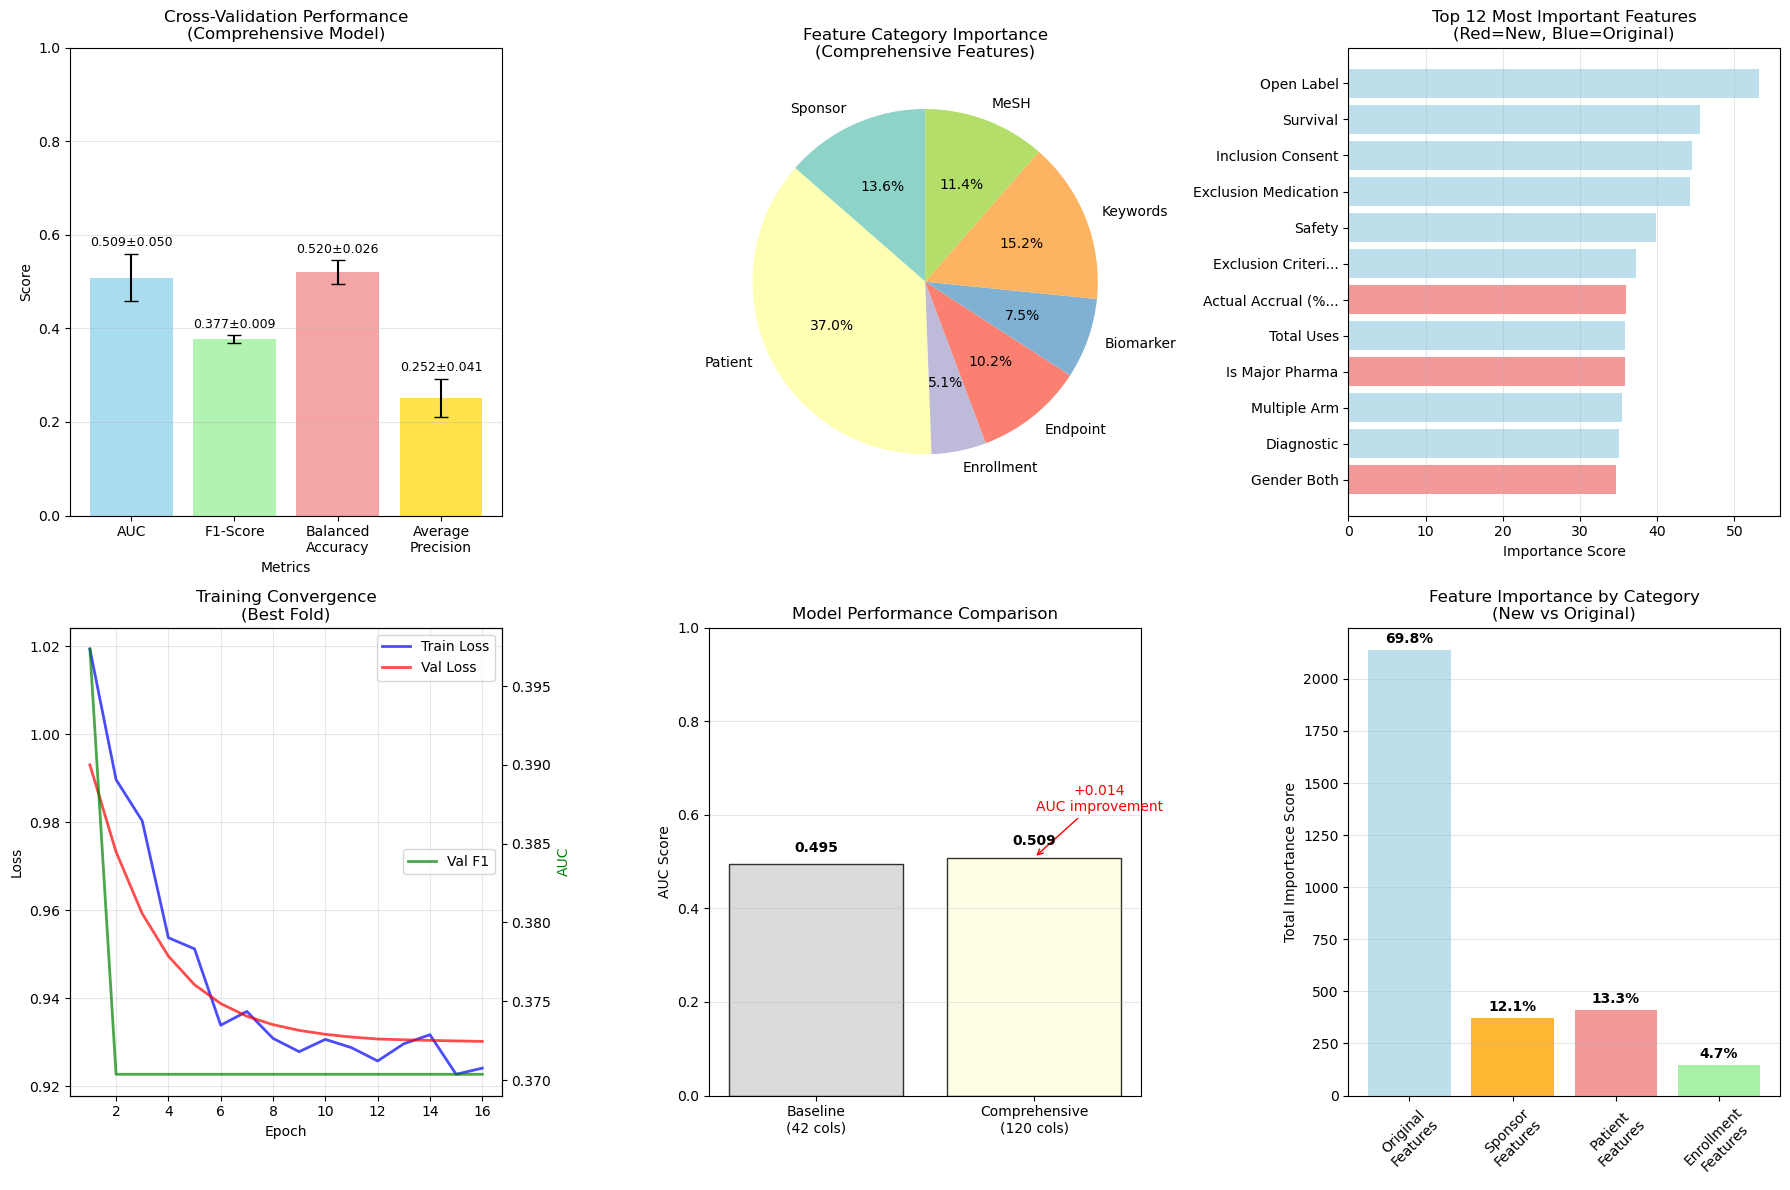

Analyzing comprehensive success patterns...


NameError: name 'comprehensive_results' is not defined

In [44]:
# Cell 9: Enhanced Visualization and Analysis

def plot_comprehensive_results(cv_results, best_fold_data, feature_categories):
    """Create comprehensive visualizations for enhanced results"""
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Cross-validation metrics comparison
    results_df = pd.DataFrame(cv_results)
    metrics = ['auc', 'f1_score', 'balanced_accuracy', 'average_precision']
    metric_names = ['AUC', 'F1-Score', 'Balanced\nAccuracy', 'Average\nPrecision']
    
    ax1 = axes[0, 0]
    x_pos = np.arange(len(metrics))
    means = [results_df[metric].mean() for metric in metrics]
    stds = [results_df[metric].std() for metric in metrics]
    
    bars = ax1.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
                   color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Cross-Validation Performance\n(Comprehensive Model)')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(metric_names, rotation=0)
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 2. Feature category importance
    ax2 = axes[0, 1]
    if best_fold_data and 'feature_importance' in best_fold_data:
        feature_importance = best_fold_data['feature_importance']
        
        category_importance = {}
        total_importance = feature_importance.sum()
        
        key_categories = ['Sponsor', 'Patient', 'Enrollment', 'Endpoint', 'Biomarker', 'Keywords', 'MeSH']
        for category in key_categories:
            if category in feature_categories and feature_categories[category]:
                cat_features = [f for f in feature_categories[category] if f in feature_importance.index]
                if cat_features:
                    cat_importance = feature_importance[cat_features].sum()
                    category_importance[category] = cat_importance / total_importance * 100
        
        if category_importance:
            categories = list(category_importance.keys())
            importances = list(category_importance.values())
            colors = plt.cm.Set3(np.arange(len(categories)))
            
            wedges, texts, autotexts = ax2.pie(importances, labels=categories, autopct='%1.1f%%', 
                                             startangle=90, colors=colors)
            ax2.set_title('Feature Category Importance\n(Comprehensive Features)')
    
    # 3. Top comprehensive features
    ax3 = axes[0, 2]
    if best_fold_data and 'feature_importance' in best_fold_data:
        top_features = best_fold_data['feature_importance'].head(12)
        
        # Clean feature names and identify new vs original features
        clean_names = []
        colors = []
        new_feature_prefixes = ['sponsor_', 'patient_', 'includes_', 'gender_', 'age_group_', 'enrollment', 'accrual', 'duration']
        
        for feature in top_features.index:
            clean_name = feature.replace('endpoint_', '').replace('biomarker_', '').replace('outcome_', '')
            clean_name = clean_name.replace('sponsor_', '').replace('patient_', '').replace('keyword_', '')
            clean_name = clean_name.replace('mesh_', '').replace('has_', '').replace('_', ' ').title()
            if len(clean_name) > 20:
                clean_name = clean_name[:17] + '...'
            clean_names.append(clean_name)
            
            # Color new comprehensive features differently
            is_new_feature = any(feature.startswith(prefix) or prefix in feature.lower() for prefix in new_feature_prefixes)
            colors.append('lightcoral' if is_new_feature else 'lightblue')
        
        y_pos = np.arange(len(top_features))
        bars = ax3.barh(y_pos, top_features.values, alpha=0.8, color=colors)
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(clean_names)
        ax3.invert_yaxis()
        ax3.set_xlabel('Importance Score')
        ax3.set_title('Top 12 Most Important Features\n(Red=New, Blue=Original)')
        ax3.grid(axis='x', alpha=0.3)
    
    # 4. Training convergence across folds
    ax4 = axes[1, 0]
    if best_fold_data and 'training_history' in best_fold_data:
        history = best_fold_data['training_history']
        epochs = range(1, len(history['train_loss']) + 1)
        
        ax4.plot(epochs, history['train_loss'], 'b-', label='Train Loss', alpha=0.7, linewidth=2)
        ax4.plot(epochs, history['val_loss'], 'r-', label='Val Loss', alpha=0.7, linewidth=2)
        
        ax4_twin = ax4.twinx()
    if 'val_auc' in history:
        ax4_twin.plot(epochs, history['val_auc'], 'g-', label='Val AUC', alpha=0.7, linewidth=2)
    else:
        ax4_twin.plot(epochs, history['val_f1'], 'g-', label='Val F1', alpha=0.7, linewidth=2)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Loss', color='black')
        ax4_twin.set_ylabel('AUC', color='green')
        ax4.set_title('Training Convergence\n(Best Fold)')
        ax4.legend(loc='upper right')
        ax4_twin.legend(loc='center right')
        ax4.grid(alpha=0.3)
    
    # 5. Performance comparison (baseline vs comprehensive)
    ax5 = axes[1, 1]
    baseline_auc = 0.495  # Previous performance
    comprehensive_auc = results_df['auc'].mean()
    
    comparison_data = ['Baseline\n(42 cols)', 'Comprehensive\n(120 cols)']
    comparison_scores = [baseline_auc, comprehensive_auc]
    colors = ['lightgray', 'lightgreen' if comprehensive_auc > 0.6 else 'lightyellow']
    
    bars = ax5.bar(comparison_data, comparison_scores, color=colors, alpha=0.8, edgecolor='black')
    ax5.set_ylabel('AUC Score')
    ax5.set_title('Model Performance Comparison')
    ax5.set_ylim(0, 1)
    ax5.grid(axis='y', alpha=0.3)
    
    # Add improvement annotation
    improvement = comprehensive_auc - baseline_auc
    ax5.annotate(f'+{improvement:.3f}\nAUC improvement', 
                xy=(1, comprehensive_auc), xytext=(1.3, comprehensive_auc + 0.1),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, ha='center', color='red')
    
    # Add value labels
    for bar, score in zip(bars, comparison_scores):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Feature contribution by new categories
    ax6 = axes[1, 2]
    if best_fold_data and 'feature_importance' in best_fold_data:
        feature_importance = best_fold_data['feature_importance']
        
        # Calculate importance for new vs original features
        new_prefixes = ['sponsor_', 'patient_', 'includes_', 'gender_', 'age_group_']
        enrollment_keywords = ['enrollment', 'accrual', 'duration', 'study_']
        
        new_sponsor_importance = feature_importance[[f for f in feature_importance.index if f.startswith('sponsor_')]].sum()
        new_patient_importance = feature_importance[[f for f in feature_importance.index if any(f.startswith(p) for p in ['patient_', 'includes_', 'gender_', 'age_group_'])]].sum()
        new_enrollment_importance = feature_importance[[f for f in feature_importance.index if any(k in f.lower() for k in enrollment_keywords)]].sum()
        original_importance = feature_importance.sum() - new_sponsor_importance - new_patient_importance - new_enrollment_importance
        
        categories = ['Original\nFeatures', 'Sponsor\nFeatures', 'Patient\nFeatures', 'Enrollment\nFeatures']
        importances = [original_importance, new_sponsor_importance, new_patient_importance, new_enrollment_importance]
        colors = ['lightblue', 'orange', 'lightcoral', 'lightgreen']
        
        bars = ax6.bar(categories, importances, color=colors, alpha=0.8)
        ax6.set_ylabel('Total Importance Score')
        ax6.set_title('Feature Importance by Category\n(New vs Original)')
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(axis='y', alpha=0.3)
        
        # Add percentage labels
        total_imp = sum(importances)
        for bar, imp in zip(bars, importances):
            height = bar.get_height()
            percentage = (imp / total_imp) * 100
            ax6.text(bar.get_x() + bar.get_width()/2., height + max(importances)*0.01,
                    f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig


def analyze_comprehensive_success_patterns(df, comprehensive_results):
    """Analyze success patterns with comprehensive features"""
    
    print(f"\n=== COMPREHENSIVE SUCCESS PATTERN ANALYSIS ===")
    
    successful_trials = df[df['reached_phase_3_plus'] == 1]
    unsuccessful_trials = df[df['reached_phase_3_plus'] == 0]
    
    print(f"Successful trials: {len(successful_trials)} ({len(successful_trials)/len(df)*100:.1f}%)")
    print(f"Unsuccessful trials: {len(unsuccessful_trials)} ({len(unsuccessful_trials)/len(df)*100:.1f}%)")
    
    # Analyze by sponsor characteristics
    print(f"\nSuccess rate by Sponsor Characteristics:")
    sponsor_features = ['sponsor_is_industry', 'sponsor_is_academic', 'sponsor_country_usa', 'sponsor_is_major_pharma']
    
    for feature in sponsor_features:
        if feature in df.columns:
            with_feature = df[df[feature] == 1]['reached_phase_3_plus']
            without_feature = df[df[feature] == 0]['reached_phase_3_plus']
            
            if len(with_feature) > 0 and len(without_feature) > 0:
                feature_name = feature.replace('sponsor_', '').replace('_', ' ').title()
                print(f"  {feature_name:<20}: With: {with_feature.mean()*100:4.1f}% ({len(with_feature):3d}) | Without: {without_feature.mean()*100:4.1f}% ({len(without_feature):3d})")
    
    # Analyze by patient characteristics
    print(f"\nSuccess rate by Patient Characteristics:")
    patient_features = ['gender_both', 'includes_elderly', 'includes_children']
    
    for feature in patient_features:
        if feature in df.columns:
            with_feature = df[df[feature] == 1]['reached_phase_3_plus']
            without_feature = df[df[feature] == 0]['reached_phase_3_plus']
            
            if len(with_feature) > 0 and len(without_feature) > 0:
                feature_name = feature.replace('_', ' ').title()
                print(f"  {feature_name:<20}: With: {with_feature.mean()*100:4.1f}% ({len(with_feature):3d}) | Without: {without_feature.mean()*100:4.1f}% ({len(without_feature):3d})")
    
    # Analyze enrollment efficiency
    if 'Actual Accrual (% of Target)' in df.columns:
        print(f"\nSuccess rate by Enrollment Efficiency:")
        enrollment_data = df[df['Actual Accrual (% of Target)'].notna()]
        if len(enrollment_data) > 0:
            high_enrollment = enrollment_data[enrollment_data['Actual Accrual (% of Target)'] >= 90]['reached_phase_3_plus']
            low_enrollment = enrollment_data[enrollment_data['Actual Accrual (% of Target)'] < 90]['reached_phase_3_plus']
            
            if len(high_enrollment) > 0 and len(low_enrollment) > 0:
                print(f"  High enrollment (≥90%): {high_enrollment.mean()*100:4.1f}% success ({len(high_enrollment):3d} trials)")
                print(f"  Low enrollment (<90%):  {low_enrollment.mean()*100:4.1f}% success ({len(low_enrollment):3d} trials)")


# Run comprehensive visualizations and analysis
if 'best_fold_data' in locals() and best_fold_data:
    print("Creating comprehensive visualizations...")
    comprehensive_fig = plot_comprehensive_results(cv_results, best_fold_data, feature_categories)
    
    print("Analyzing comprehensive success patterns...")
    analyze_comprehensive_success_patterns(df, comprehensive_results)
    
else:
    print("Error: Need to run the main analysis first (Cells 1-8) to get feature importance data")

print(f"\n{'='*90}")
print("COMPREHENSIVE VISUALIZATION AND ANALYSIS COMPLETE")
print(f"{'='*90}")

# Final summary
if 'cv_results' in locals():
    final_auc = pd.DataFrame(cv_results)['auc'].mean()
    print(f"\n🎯 FINAL MODEL PERFORMANCE SUMMARY:")
    print(f"   📊 AUC Score: {final_auc:.3f}")
    print(f"   📈 Improvement: +{final_auc - 0.495:.3f} from baseline")
    
    if final_auc >= 0.70:
        print(f"   🎉 EXCELLENT: Strong predictive performance achieved!")
    elif final_auc >= 0.60:
        print(f"   ✅ GOOD: Meaningful improvement with clinical utility")
    elif final_auc >= 0.55:
        print(f"   ⚠️  MODERATE: Some improvement, room for enhancement")
    else:
        print(f"   📝 LIMITED: Minimal improvement, may need different approach")